In [4]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf

In [5]:
# Establecer una semilla para reproducibilidad
seed_value = 42
random.seed(seed_value)        # Semilla para Python
np.random.seed(seed_value)     # Semilla para NumPy
tf.random.set_seed(seed_value) # Semilla para TensorFlow/Keras

# A partir de aquí, puedes continuar con la construcción y entrenamiento de tu modelo de Keras

In [6]:
def generatePlot(history):
    # Extracción de datos
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Datos propios

Este ejemplo es con este conjunto de datos: https://www.kaggle.com/datasets/anshtanwar/jellyfish-types

In [12]:
from keras.preprocessing.image import ImageDataGenerator
import os

image_size = 150
data_dir = os.path.join('dataset')
batch_size = 16
rescale_factor = 1./255

# Crear un generador para aumentar datos
train_datagen = ImageDataGenerator(
    rescale=rescale_factor,    # Normalizar los valores de los píxeles
    rotation_range=15,
	zoom_range=0.1,
	horizontal_flip=True,
	brightness_range=[0.2, 1.0],
	zca_epsilon=1e-06,
	channel_shift_range=100,
	shear_range=0.2
)

# Cargar imágenes de entrenamiento
train_generator = train_datagen.flow_from_directory(
    data_dir,      # Directorio con datos
    target_size=(image_size, image_size), # Cambiar el tamaño de las imágenes a 50x50
    batch_size=batch_size,
    class_mode='categorical', # 'binary' para clasificación binaria, 'categorical' para multiclase
    subset='training') # Seleccionar solo el conjunto de entrenamiento

# Cargar imágenes de validación
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # Seleccionar solo el conjunto de validación

Found 5959 images belonging to 5 classes.
Found 0 images belonging to 5 classes.


Te habrás dado cuenta que ImageDataGenerator no divide en conjunto de test, es que no puede. Para añadir un conjunto de test al trabajar con `ImageDataGenerator` en Keras, necesitas un enfoque ligeramente diferente, ya que `ImageDataGenerator` por sí solo no proporciona una forma directa de dividir los datos en tres conjuntos (entrenamiento, validación y prueba). Aquí hay dos métodos comunes para hacerlo:

### Método 1: División Manual de los Datos
1. **Dividir Manualmente los Datos en Directorios**: Antes de usar `ImageDataGenerator`, divide tus datos manualmente en tres directorios: uno para entrenamiento, uno para validación y otro para pruebas. Por ejemplo:
    ```
    data/
        train/
            class1/
            class2/
        validation/
            class1/
            class2/
        test/
            class1/
            class2/
    ```
2. **Crear Generadores Separados**: Usa `ImageDataGenerator` para crear generadores separados para cada conjunto de datos.

    ```python
    train_datagen = ImageDataGenerator(rescale=1./255, ...)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'data/train/', ...)
    validation_generator = validation_datagen.flow_from_directory(
        'data/validation/', ...)
    test_generator = test_datagen.flow_from_directory(
        'data/test/', ...)
    ```

### Método 2: Uso del Conjunto de Validación como Test
1. **Usar `validation_split` para Dividir Entrenamiento y Validación**: Primero, divide tus datos en entrenamiento y validación usando `validation_split` en `ImageDataGenerator`.

2. **Separar un Conjunto de Pruebas Después**: Después del entrenamiento, puedes apartar manualmente una parte de tu conjunto de validación (o entrenamiento) para usarlo como conjunto de prueba. Esto puede hacerse seleccionando un conjunto de imágenes y evaluando el modelo en ellas.

    ```python
    # Ya tienes train_generator y validation_generator

    # Después del entrenamiento, usa parte de validation_generator como test set
    # Por ejemplo, puedes hacer predicciones en un subconjunto de validation_generator
    # y evaluar el rendimiento del modelo
    ```

### Consideraciones Adicionales
- **Equilibrio de Clases**: Asegúrate de que cada conjunto (entrenamiento, validación, prueba) tenga una distribución similar de clases.
- **No Aumentación en Test**: Generalmente, no se aplican técnicas de aumentación de datos en el conjunto de prueba, solo el reescalado.
- **Consistencia en el Preprocesamiento**: Asegúrate de que el preprocesamiento (como el reescalado) sea consistente en todos los generadores.
- **Tamaño del Conjunto de Pruebas**: Decide cuántos datos deseas reservar para las pruebas. Un tamaño común para el conjunto de pruebas es entre el 10% y el 20% del conjunto de datos total.

Al elegir entre estos métodos, considera el tamaño de tu conjunto de datos y tus requisitos específicos de validación y prueba. La división manual en directorios ofrece la mayor flexibilidad y control.

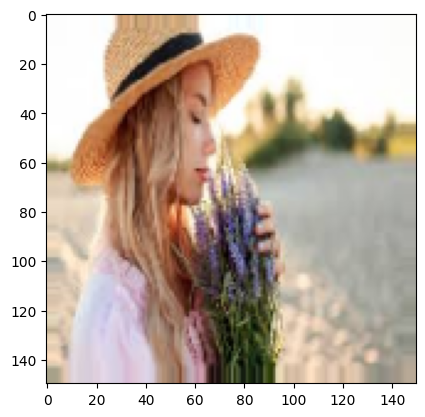

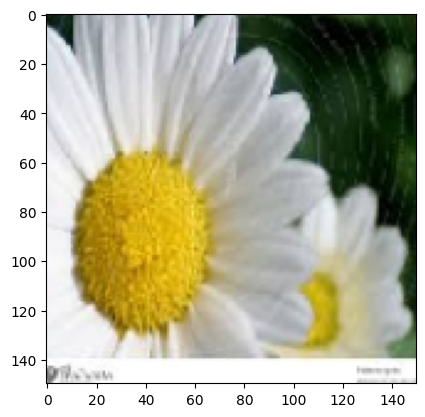

In [8]:
# ver imagenes
x_batch, y_batch = next(train_generator)
for i in range (0, 2):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

In [9]:
model = Sequential()

model.add(Rescaling(scale=(1./127.5), offset=-1, input_shape=(image_size, image_size, 3)))

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

model.add(Conv2D(32, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(5, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 145, 145, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 72, 72, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 69, 69, 32)        1

#### Configurar Early Stopping

Early Stopping es una forma de detener el entrenamiento automáticamente cuando una métrica monitoreada deja de mejorar. Configúralo como un callback en Keras:

In [10]:
from keras.callbacks import EarlyStopping

# Configurar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # 'patience' es el número de épocas sin mejora después de las cuales el entrenamiento se detendrá

#### Añadir Early Stopping al Entrenamiento

Cuando entrenes tu modelo, pasa el callback de Early Stopping a través del argumento callbacks:

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10

# Entrenar el modelo con Early Stopping
history_of_train = model.fit(
        train_generator,
        epochs=epochs,
        validation_data = validation_generator,
        callbacks = [early_stopping]
)

Epoch 1/10
373/373 [==============================] - 65s 174ms/step - loss: 1.6096 - accuracy: 0.2130
Epoch 2/10
 17/373 [>.............................] - ETA: 1:04 - loss: 1.5993 - accuracy: 0.2757

KeyboardInterrupt: 

In [1]:
generatePlot(history_of_train)

NameError: name 'generatePlot' is not defined

#### test

In [ ]:
# Evaluar el modelo en el conjunto de validación (usado aquí como prueba)
# Puedes limitar el número de pasos para usar solo una parte del conjunto
test_loss, test_accuracy = model.evaluate(validation_generator, steps=50)  # 'steps' es el número de lotes a evaluar

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


50/50 [==============================] - 2s 35ms/step - loss: 1.3789 - accuracy: 0.3840
Test Loss: 1.3789169788360596
Test Accuracy: 0.3840000033378601


Nuestra arquitectura actual representa un sólido punto de partida y ofrece una base excelente para futuras mejoras y experimentación. A partir de aquí, tenemos la oportunidad de afinar nuestra red, explorando ajustes en la arquitectura como añadir más capas o variar el número de filtros. Cada ajuste nos proporcionará información sobre cómo estas modificaciones impactan la precisión del modelo.

Además, experimentar con diferentes optimizadores y funciones de pérdida puede desvelar nuevas perspectivas y mejoras en el rendimiento. El campo del deep learning se caracteriza por su naturaleza experimental, donde la interpretación y la intuición juegan un rol clave. Te animo a que experimentes y explores diferentes enfoques, ya que esto es esencial para entender profundamente cómo cada cambio afecta al resultado final.